In [1]:
import os, sys
from numpy import *
from scipy.stats import lognorm
import matplotlib.pyplot as plt
import numpy as np
import fftlog, module, config 
from fftlog import FFTLog

JAX mode:  False


### Showcasing FFTLog

The FFTLog of a function $P(k)$ on $N+1$ log-spaced points between $k_\ell \in [k_{\rm min}, k_{\rm max}]$ reads: 
\begin{equation}
P(k) \approx \sum_{\alpha=-N/2}^{N/2} c_\alpha \ k^{-2\nu_\alpha} \ ,
\end{equation}
where $-2\nu_\alpha = \nu +i \eta_\alpha$, with $\nu$ a fixed real number called the bias, and we have the coefficients $c_\alpha$ and the frequencies $\eta_\alpha$ defined as: 
\begin{equation}
c_\alpha = \frac{1}{N} \sum_{\ell=0}^{N+1} P(k_\ell) k_\ell^{-\nu} k_{\rm min}^{-i\eta_\alpha} e^{-2i\alpha \ell / N} \ , \qquad \eta_\alpha = \frac{2\pi \alpha}{\log(k_{\rm max}/k_{\rm min})} \ . 
\end{equation}

It is called 'FFTLog' simply because numerically, such decomposition is obtained performing an FFT in log-space: 
\begin{equation}
\sum_{\alpha} c_\alpha \ k^{\nu + i\eta_\alpha} \equiv k^\nu \sum_{\alpha=-N/2}^{N/2} c_\alpha  e^{i \eta_\alpha \log(k)} \ .
\end{equation}

Here is a test function `pk`
- the function should go asymptotically to 0 on the left and the right as the FFTLog will transform the function into a periodic one. 

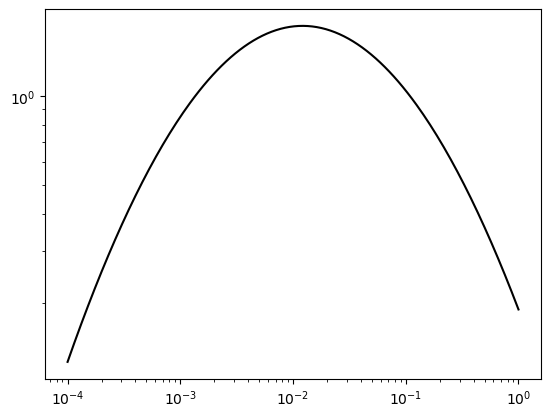

In [2]:
kk = np.logspace(-4, 0, 200)
pk = lognorm.pdf(kk, 2.1) 

plt.plot(kk, pk, 'k')
plt.xscale('log')
plt.yscale('log')
plt.show()

Here is how to call and configure the `FFTLog`
- `Nmax` is the number of log-spaced points used to perform the FFT  
- `xmin` and `xmax` are the FFT boundaries. If the function to FFT is specified on a domain smaller than `[xmin, xmax]`, it will be extrapolated in log-log space. It is usually a good idea to choose the range a bit larger than the domain over which we want the decomposition to be faithful to the original （see also comment below). 
- `bias` is a real non-integer number that can be chosen to assure convergence of certain integrals using the FFTLog decomposition

In [3]:
fftsettings = dict(Nmax=64, xmin=1e-5, xmax=1e3, bias=-0.01, window=0.2)
fft = FFTLog(**fftsettings)

Here is the FFTLog decomposition of the `pk`  
- In general, it is a good idea to apply a `window` to the function (beyond the domain where we want its decomposition to be faithful to the original) on the left and right to let it goes smoothly to 0 in order to avoid ringing effect. 

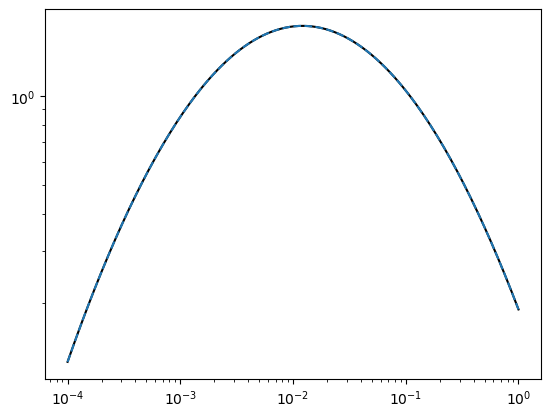

In [4]:
pk_rec = fft.sumCoefxPow(kk, pk, kk) # input k, input pk, output k

plt.plot(kk, pk, 'k')
plt.plot(kk, pk_rec, '--')

plt.xscale('log')
plt.yscale('log')
plt.show()

Here is what `fft.sumCoefxPow()` above does: 

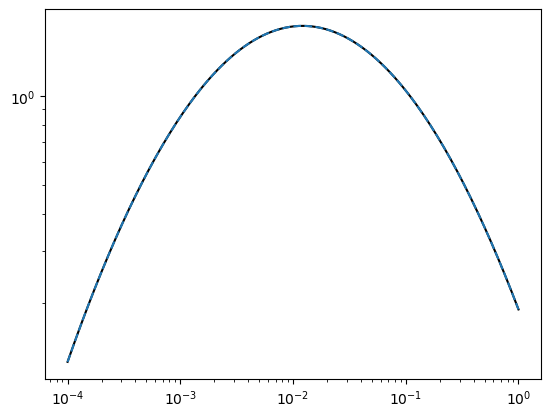

In [5]:
Coef = fft.Coef(kk, pk) # get the c_\alpha

pk_rec = np.empty_like(kk)
for i, k in enumerate(kk):
    pk_rec[i] = np.real(np.sum(Coef * k**fft.Pow))
    
plt.plot(kk, pk, 'k')
plt.plot(kk, pk_rec, '--')

plt.xscale('log')
plt.yscale('log')
plt.show()

Now consider the code in JAX

In [6]:
import jax 
import jax.numpy as jnp
from jax.config import config as jax_config
jax_config.update("jax_enable_x64", True) 

/var/folders/pb/qmsvthxs5cv4cnk3lwh2wy180000gn/T/ipykernel_22010/1140817039.py:3: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config as jax_config


In [7]:
config.set_jax_enabled(True) # Enable JAX
import importlib
importlib.reload(module)
importlib.reload(fftlog)

using jax
JAX mode:  True


<module 'fftlog' from '/Users/alexreeves/Documents/local_software/fftlog/fftlog.py'>

In [8]:
fft = FFTLog(**fftsettings)

In [9]:
def get_pkrec(kk, pk):
    fft_settings = dict(Nmax=64, xmin=1e-5, xmax=1e3, bias=-0.01, window=0.2)
    fft = FFTLog(**fft_settings)
    pk_rec = fft.sumCoefxPow(kk, pk, kk) # input k, input pk, output k
    return pk_rec

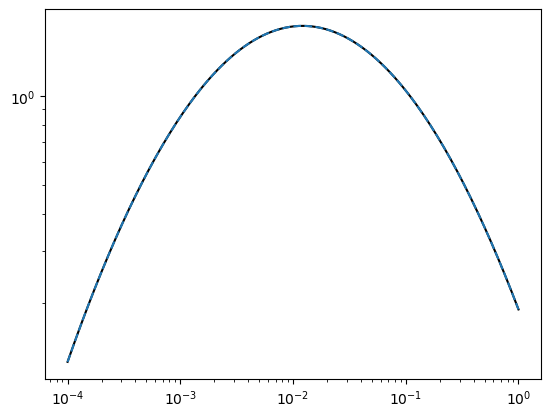

In [10]:
pk_rec = get_pkrec(kk, pk)

plt.plot(kk, pk, 'k')
plt.plot(kk, pk_rec, '--')

plt.xscale('log')
plt.yscale('log')
plt.show()

Now with JIT compilation

In [11]:
get_pk_rec_jit = jax.jit(get_pkrec)

kk_jax = jnp.array(kk)
pk_jax = jnp.array(pk)

In [14]:
#run once to compile
out = get_pk_rec_jit(kk_jax, pk_jax)

In [16]:
# time how long 1000 calls of the jitted function take using time package 
import time
start = time.time()
for i in range(1000):
    pk_rec = get_pk_rec_jit(kk_jax, pk_jax)
end = time.time()
print('Time taken for per call of get_pk_rec_jit:', (end - start)*1000, 'ms')

Time taken for per call of get_pk_rec_jit: 231.84680938720703 ms
